In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
sequence_length = 10
num_hours_ahead = 5

In [13]:
# Load the arrays from the .npy files
X_train = np.load('data2/X_train.npy')
y_train = np.load('data2/y_train.npy')
X_val = np.load('data2/X_val.npy')
y_val = np.load('data2/y_val.npy')
X_test = np.load('data2/X_test.npy')
y_test = np.load('data2/y_test.npy')

In [17]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2024-02-16 02:36:51.991128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Recall
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam

In [19]:
# Indices for each class
indices_class_0 = np.where(y_train == 0)[0]
indices_class_1 = np.where(y_train == 1)[0]

In [20]:
# Function to create the model with different hyperparameters
def create_model(n_lstm_units=100, dropout_rate=0.2):
    model = Sequential([
        LSTM(n_lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(n_lstm_units),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])
    return model

# Grid Search to find the best parameters

In [21]:
# Define hyperparameters to test
lstm_units_options = [50, 75, 100, 125, 150]
dropout_rate_options = [0.2, 0.3, 0.4]
batch_size_options = [64]
num_epochs = 5  # Adjust the number of epochs for your experiments

# Store the results
results = []

# Loop over all possible combinations of hyperparameters
for n_units in lstm_units_options:
    for dropout_rate in dropout_rate_options:
        for batch_size in batch_size_options:
            print(f"Testing model with {n_units} LSTM units, dropout rate {dropout_rate}, batch size {batch_size}")
            # Create the model with the current set of hyperparameters
            model = create_model(n_lstm_units=n_units, dropout_rate=dropout_rate)

            for epoch in range(num_epochs):
                # Randomly sample indices from the majority class to match the minority class size
                sampled_majority_indices = np.random.choice(indices_class_0, size=len(indices_class_1), replace=False)
                
                # Combine sampled majority indices with all minority class indices
                combined_indices = np.concatenate([sampled_majority_indices, indices_class_1])
                
                # Shuffle the combined indices
                np.random.shuffle(combined_indices)

                # Use the combined indices to create the training dataset for this epoch
                X_train_epoch = X_train[combined_indices]
                y_train_epoch = y_train[combined_indices]

                # Train the model on this epoch's data
                model.fit(X_train_epoch, y_train_epoch, epochs=1, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
            
            # Evaluate the model on the validation set
            val_loss, val_accuracy, val_recall = model.evaluate(X_val, y_val, verbose=0)
            print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Recall: {val_recall}")
            
            # Append the results
            results.append((n_units, dropout_rate, batch_size, val_loss, val_accuracy, val_recall))

# After running the experiments, analyze the results to find the best set of hyperparameters based on validation performance
best_result = sorted(results, key=lambda x: x[4], reverse=True)[0]  # Example: sort by accuracy
print(f"Best Hyperparameters: LSTM Units: {best_result[0]}, Dropout Rate: {best_result[1]}, Batch Size: {best_result[2]}")
print(f"Validation Loss: {best_result[3]}, Validation Accuracy: {best_result[4]}, Validation Recall: {best_result[5]}")


Testing model with 50 LSTM units, dropout rate 0.2, batch size 64


2024-02-16 02:37:01.849306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10398 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1
2024-02-16 02:37:07.363401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-16 02:37:07.519076: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563547508680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-16 02:37:07.519145: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-02-16 02:37:07.545782: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-16 02:37:07.802291: I ./tensorflow/compiler/jit/device_compiler.h:186] C

Validation Loss: 0.4191944897174835, Validation Accuracy: 0.7994102239608765, Validation Recall: 0.8245278596878052
Testing model with 50 LSTM units, dropout rate 0.3, batch size 64
Validation Loss: 0.4379529058933258, Validation Accuracy: 0.7881125807762146, Validation Recall: 0.8337888121604919
Testing model with 50 LSTM units, dropout rate 0.4, batch size 64
Validation Loss: 0.41574418544769287, Validation Accuracy: 0.8048403263092041, Validation Recall: 0.8019979596138
Testing model with 75 LSTM units, dropout rate 0.2, batch size 64
Validation Loss: 0.41887685656547546, Validation Accuracy: 0.7985730767250061, Validation Recall: 0.8289912939071655
Testing model with 75 LSTM units, dropout rate 0.3, batch size 64
Validation Loss: 0.4258643090724945, Validation Accuracy: 0.7957072257995605, Validation Recall: 0.8249225616455078
Testing model with 75 LSTM units, dropout rate 0.4, batch size 64
Validation Loss: 0.4180811047554016, Validation Accuracy: 0.7955412864685059, Validation Re

# Combining Test Validation using best hyperparameter

In [24]:

# Combine the features (X) from the training and validation sets
X_combined = np.concatenate((X_train, X_val), axis=0)

# Combine the labels (y) from the training and validation sets
y_combined = np.concatenate((y_train, y_val), axis=0)

# Indices for each class in the combined dataset
indices_class_0_combined = np.where(y_combined == 0)[0]
indices_class_1_combined = np.where(y_combined == 1)[0]

# Create the model outside the loop to avoid reinitializing it in each epoch
model = create_model(n_lstm_units=125, dropout_rate=0.2)

# Assuming num_epochs and batch_size are defined
for epoch in range(5):
    # Randomly sample indices from the majority class (class 0) to match the minority class (class 1) size
    sampled_majority_indices = np.random.choice(indices_class_0_combined, size=len(indices_class_1_combined), replace=False)
    
    # Combine sampled majority indices with all minority class indices
    combined_indices = np.concatenate([sampled_majority_indices, indices_class_1_combined])
    
    # Shuffle the combined indices
    np.random.shuffle(combined_indices)
    
    # Use the combined indices to create the balanced training dataset for this epoch
    X_train_epoch = X_combined[combined_indices]
    y_train_epoch = y_combined[combined_indices]
    
    # Train the model on this epoch's balanced data
    # Make sure to replace 'epochs=1' with the correct number or remove it if you're iterating externally
    model.fit(X_train_epoch, y_train_epoch, epochs=1, batch_size=64, validation_data=(X_test, y_test), verbose=1)

4170/4170 [==============================] - 33s 8ms/step - loss: 0.4113 - accuracy: 0.8101 - recall_17: 0.8237 - val_loss: 0.4057 - val_accuracy: 0.8055 - val_recall_17: 0.8173


# Evaluating the model

In [25]:
test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Recall: {test_recall}")

4149/4149 [==============================] - 14s 3ms/step - loss: 0.4057 - accuracy: 0.8055 - recall_17: 0.8173
Test Loss: 0.4057289958000183
Test Accuracy: 0.8055089116096497
Test Recall: 0.817329466342926


In [26]:
predictions = model.predict(X_test)
predicted_classes = (predictions >= 0.5).astype(int).flatten()

4149/4149 [==============================] - 12s 3ms/step


In [27]:
from tensorflow.math import confusion_matrix

conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

tf.Tensor(
[[79137 19607]
 [ 6215 27808]], shape=(2, 2), dtype=int32)


In [36]:
np.array([['True Negative', 'False Positive'],
 ['False Negative', 'True Positive']])

array([['True Negative', 'False Positive'],
       ['False Negative', 'True Positive']], dtype='<U14')

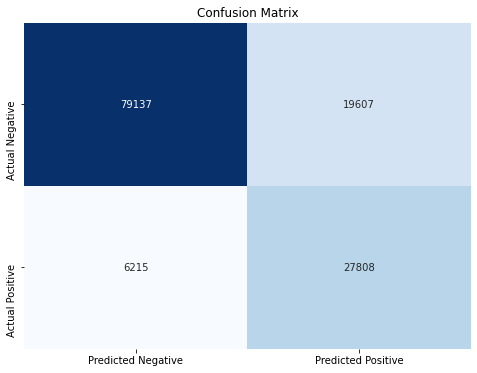

In [37]:
# Since your confusion matrix is already a TensorFlow tensor, convert it to a numpy array for visualization.
conf_matrix_np = conf_matrix.numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_np, annot=True, fmt="d", cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])


plt.title('Confusion Matrix')
plt.show()

In [38]:
# Extracting the counts from the confusion matrix
TN, FP, FN, TP = conf_matrix.numpy().ravel()

# Calculating metrics
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_Score = 2 * (Precision * Recall) / (Precision + Recall)

print(f'Accuracy: {Accuracy}')
print(f'Precision: {Precision}')
print(f'Recall: {Recall}')
print(f'F1 Score: {F1_Score}')

Accuracy: 0.8055088990487094
Precision: 0.5864810713909101
Recall: 0.8173294536049143
F1 Score: 0.6829244333112306


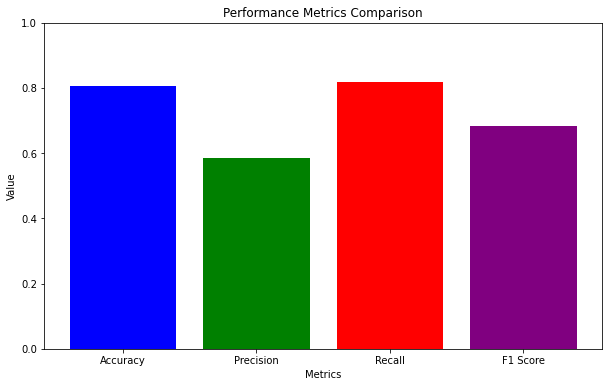

In [39]:

# Metrics values
metrics_values = [Accuracy, Precision, Recall, F1_Score]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple'])

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Performance Metrics Comparison')
plt.ylim(0, 1)  # Since metric values range from 0 to 1
plt.show()

# AUROC

In [40]:
# Assuming `model` is your trained TensorFlow model and `X_test` is your test dataset
y_probabilities = model.predict(X_test).ravel()


4149/4149 [==============================] - 11s 3ms/step


In [41]:
y_probabilities

array([0.9322302 , 0.9349618 , 0.9350221 , ..., 0.00113248, 0.00134409,
       0.00140318], dtype=float32)

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate AUROC
auroc = roc_auc_score(y_test, y_probabilities)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)


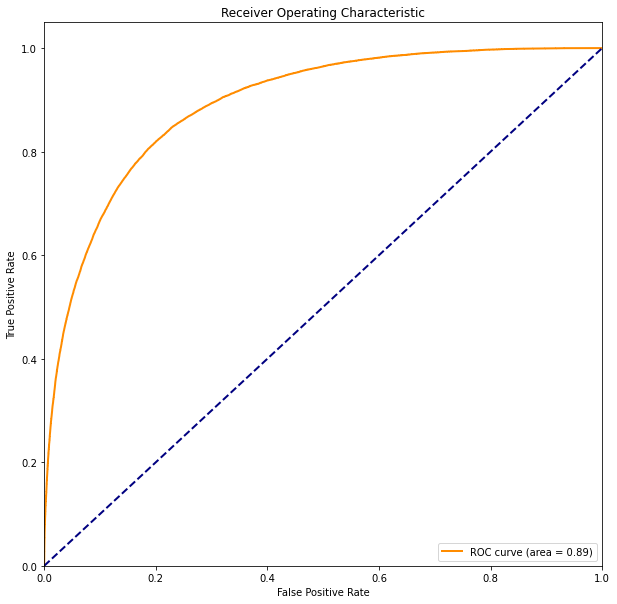

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10)) 
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()